In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


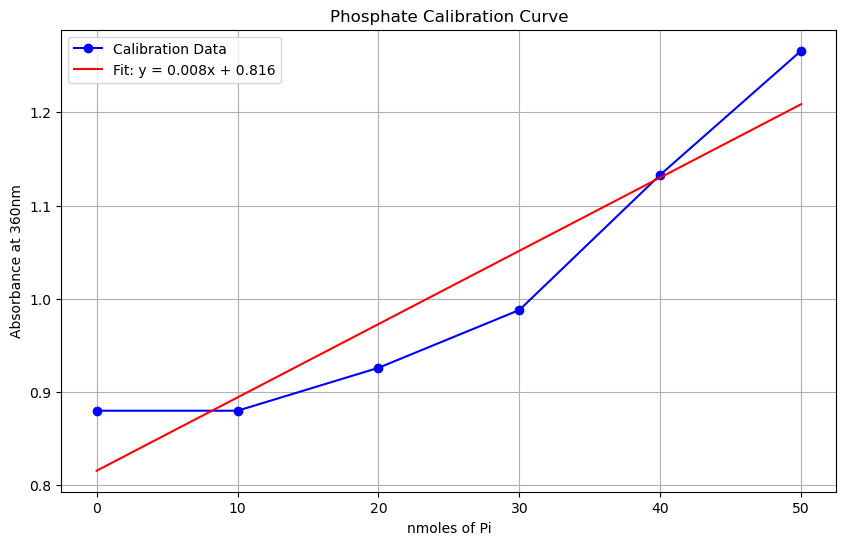

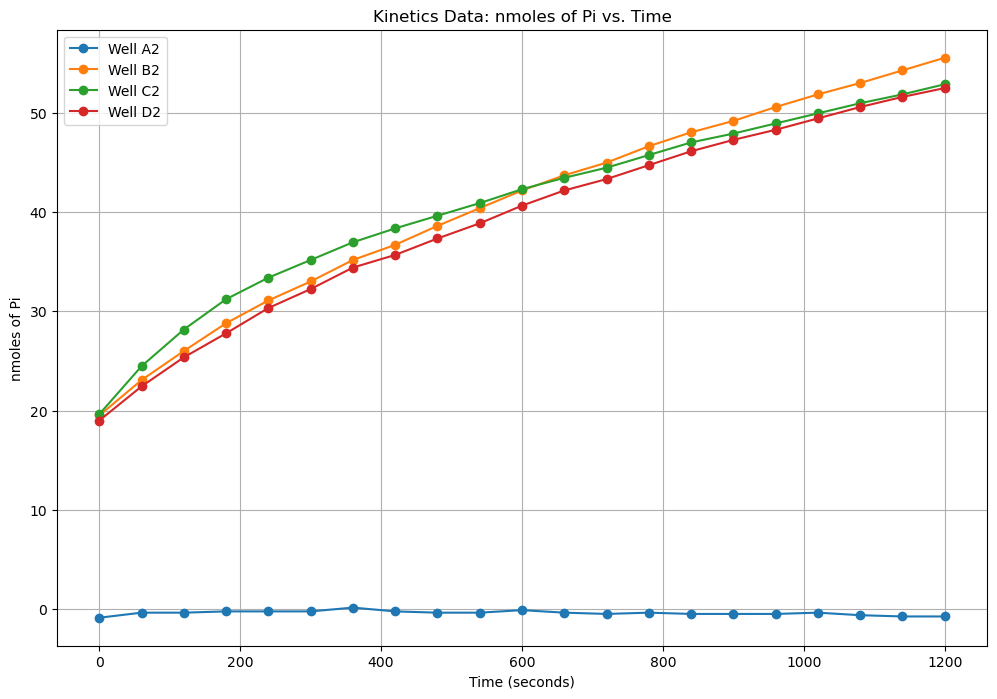

Initial reaction rate for Well A: 0.002 nmoles/sec
Initial reaction rate for Well B: 0.048 nmoles/sec
Initial reaction rate for Well C: 0.057 nmoles/sec
Initial reaction rate for Well D: 0.047 nmoles/sec


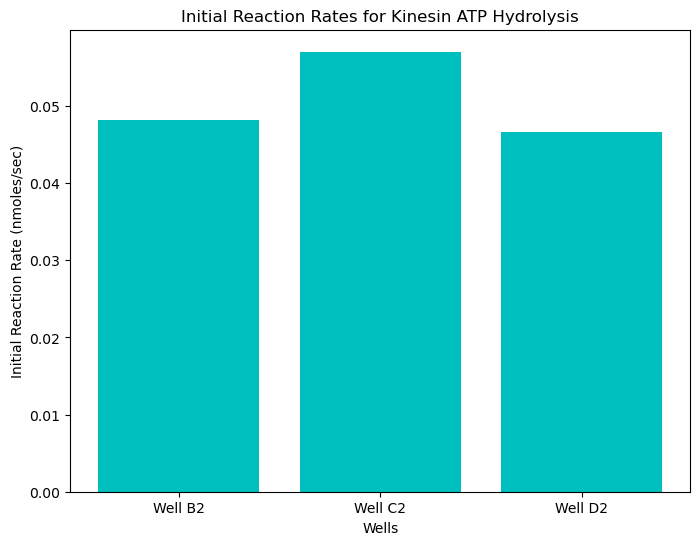

In [2]:
# Load the calibration data
calibration_data = pd.read_excel("../data/phosphate-calibration-curve.xlsx", skiprows=36).iloc[:1, 1:11]

# Load the kinetics data
kinetics_data = pd.read_excel("../data/KHC-test.xlsx", skiprows=36).iloc[:21, 1:7]

# Extract the nmoles of Pi and corresponding absorbance values
nmoles_of_Pi = np.array([0, 10, 20, 30, 40, 50])
absorbance_values = calibration_data.iloc[0, 2:8].astype(float).values

# Reshape data for linear regression
nmoles_of_Pi = nmoles_of_Pi.reshape(-1, 1)
absorbance_values = absorbance_values.reshape(-1, 1)

# Perform linear regression to get the calibration curve equation
reg = LinearRegression().fit(nmoles_of_Pi, absorbance_values)
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]

# Plot the calibration curve
plt.figure(figsize=(10, 6))
plt.plot(nmoles_of_Pi, absorbance_values, marker='o', linestyle='-', color='b', label='Calibration Data')
plt.plot(nmoles_of_Pi, reg.predict(nmoles_of_Pi), color='r', label=f'Fit: y = {slope:.3f}x + {intercept:.3f}')
plt.xlabel('nmoles of Pi')
plt.ylabel('Absorbance at 360nm')
plt.title('Phosphate Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

# Ensure the 'Time' column is in string format
kinetics_data['Time'] = kinetics_data['Time'].astype(str)

# Filter out rows where the time column does not match the expected time format
kinetics_data = kinetics_data[kinetics_data['Time'].str.match(r'^\d{2}:\d{2}:\d{2}$', na=False)]

# Convert time to a numeric format for plotting
time_numeric = pd.to_datetime(kinetics_data['Time'], format='%H:%M:%S')
time_numeric = (time_numeric - time_numeric.min()).dt.total_seconds()

# Extract absorbance values from the kinetics data and transform to nmoles of Pi
kinetics_absorbance = kinetics_data.iloc[:, 2:6].astype(float)
kinetics_moles_of_Pi = kinetics_absorbance.apply(lambda x: (x - intercept) / slope)

# Plot kinetics data (nmoles of Pi vs. time)
plt.figure(figsize=(12, 8))
plt.plot(time_numeric, kinetics_moles_of_Pi['A2'], label='Well A2', marker='o')
plt.plot(time_numeric, kinetics_moles_of_Pi['B2'], label='Well B2', marker='o')
plt.plot(time_numeric, kinetics_moles_of_Pi['C2'], label='Well C2', marker='o')
plt.plot(time_numeric, kinetics_moles_of_Pi['D2'], label='Well D2', marker='o')
plt.xlabel('Time (seconds)')
plt.ylabel('nmoles of Pi')
plt.title('Kinetics Data: nmoles of Pi vs. Time')
plt.legend()
plt.grid(True)
plt.show()

# Calculate initial reaction rates (change in nmoles of Pi per unit time)
initial_time_points = 5
initial_rates = []

for column in kinetics_moles_of_Pi.columns:
    initial_rate = np.polyfit(time_numeric[:initial_time_points], kinetics_moles_of_Pi[column][:initial_time_points], 1)[0]
    initial_rates.append(initial_rate)

# Display initial reaction rates
for i, rate in enumerate(initial_rates, start=1):
    print(f"Initial reaction rate for Well {chr(64+i)}: {rate:.3f} nmoles/sec")

# Plot the initial reaction rates
plt.figure(figsize=(8, 6))
plt.bar(['Well B2', 'Well C2', 'Well D2'], initial_rates[1:], color='c')
plt.xlabel('Wells')
plt.ylabel('Initial Reaction Rate (nmoles/sec)')
plt.title('Initial Reaction Rates for Kinesin ATP Hydrolysis')
plt.show()
